In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.io import mmread
from itertools import cycle
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

## 1. Import pure data extracted from initial analysis in R

In [2]:
# Change directory

print("Original working directory: {0}".format(os.getcwd()))

path = '/Users/ryanyutian/Desktop/PBMC68k_project/input_data_pure/all'

try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except NotADirectoryError:
    print("{0} is not a directory".format(path))
except PermissionError:
    print("You do not have permissions to change to {0}".format(path))

Original working directory: /Users/ryanyutian/Desktop/PBMC68k_project/python_scripts
Current working directory: /Users/ryanyutian/Desktop/PBMC68k_project/input_data_pure/all


In [3]:
# Obtain all normalized expression arrays and save their variable names for later use 

normalized_expression_pure_array_names = []

for file_name in sorted([i for i in os.listdir(path) if i.startswith('normalized_expression')]):
    
    print('Analyzing: ' + file_name)
    print('Current Time =', datetime.now().strftime("%H:%M:%S"))
    
    # Import sparse matrix of normalized expression then turn into np.array
    # (e.g., 'normalized_expression_1' would be mtx for all normalized expressions for cell type 1)
    temp_mtx = mmread(file_name)
    
    array_name = file_name[:-4]
    globals()[array_name] = temp_mtx.toarray(order='C')

    # Add name of the global array variable to the list of names
    normalized_expression_pure_array_names.append(array_name)

Analyzing: normalized_expression_1.mtx
Current Time = 01:13:44
Analyzing: normalized_expression_10.mtx
Current Time = 01:14:02
Analyzing: normalized_expression_2.mtx
Current Time = 01:14:04
Analyzing: normalized_expression_3.mtx
Current Time = 01:14:14
Analyzing: normalized_expression_4.mtx
Current Time = 01:14:23
Analyzing: normalized_expression_5.mtx
Current Time = 01:14:34
Analyzing: normalized_expression_6.mtx
Current Time = 01:14:45
Analyzing: normalized_expression_7.mtx
Current Time = 01:14:55
Analyzing: normalized_expression_8.mtx
Current Time = 01:15:07
Analyzing: normalized_expression_9.mtx
Current Time = 01:15:18


In [5]:
normalized_expression_pure_array_names.remove('normalized_expression_10')

In [7]:
# Concatenate all the normalized expression arrays to generate input data and labels

normalized_expression_pure_array = []
cell_labels_pure = []

for array_name in normalized_expression_pure_array_names:

    for cell in globals()[array_name]:
        
        # Append the expression profile of each cell
        normalized_expression_pure_array.append(cell)
        
        # Append label of the cell based on array name (e.g., 10, 11, ...etc.)
        # Note that -1 is applied to all labels due to R to Python transition
        cell_labels_pure.append(int(array_name.split('_')[2]) - 1)
    
normalized_expression_pure_array = np.array(normalized_expression_pure_array)
cell_labels_pure = np.array(cell_labels_pure)

## 2. MLP using PyTorch to train on pure data

In [8]:
# Split training and testing set from the pure data

X_train, X_test, y_train, y_test = \
train_test_split(normalized_expression_pure_array, cell_labels_pure, test_size=0.20)

In [9]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([7378, 6724, 8398, 8201, 9601, 8150, 8184, 8041, 8957]))

In [10]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([1854, 1661, 2081, 2062, 2352, 2074, 2025, 2044, 2256]))

In [15]:
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

trainloader = DataLoader(train_data, shuffle=True, batch_size=100)

In [2]:
# Define Neural Network architecture
class MLPNNet(nn.Module):
   
    def __init__(self, layer_size_list, output_size):
       
        super(MLPNNet, self).__init__()
        
        # Save some model parameters
        self.input_size = layer_size_list[0]
        self.output_size = output_size
        
        # Define hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(layer_size_list)-1):
            self.hidden.append(nn.Linear(layer_size_list[k], layer_size_list[k+1]))
       
        # Last hidden layer to output layer
        self.out = nn.Linear(layer_size_list[-1], output_size)
       
        # Define dropout layer (p=0.2) 
        # Dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    # ReLu activation function used for hidden layers
    def forward(self, x):
        
        # Feedforward
        for layer in self.hidden:
            x = F.relu(layer(x))
            x = self.dropout(x)

        # Generate output
        output= self.out(x)
        
        return output

In [3]:
def get_label_from_MLP_output(output):
    
    # Apply softmax function to get probability for each class (one-hot encoding)
    pred = F.softmax(output, dim = 1)
    
    # Convert prediction back to numpy array
    MLP_dec = pred.detach().numpy()
    
    # Get predicted labels from probabilities
    MLP_predicted_labels = np.argmax(MLP_dec, axis=1)

    return MLP_predicted_labels

In [50]:
len(normalized_expression_pure_array)

92043

## 3. Training of MLP: with batching on training data 

For the 92043 cells in 'pure' data, batch size is set to 100

In [29]:
# Initialize the NN with input_size, hidden_size, and output_size, and define loss function and optimizer
model = MLPNNet([32738, 100, 100], 9)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Number of times that the MLP will be trained on the train set
n_epochs = 500

# Lists to record model training and testing performance
train_loss_avg = []
test_loss = []
train_accuracy_avg = []
test_accuracy = []

print('Training ...')

# Loop through the training set to update parameters
for epoch in range(n_epochs):
    
    # Train the model
    model.train()

    # Initiate training performance calculation
    train_loss_avg.append(0)
    train_accuracy_avg.append(0)
    num_batches = 0
    
    for cell_batch, label_batch in trainloader:

        # Get an output by feeding data into the model
        out = model(torch.from_numpy(np.asarray(cell_batch)).float())

        # Compute loss from output
        loss = criterion(out, torch.from_numpy(np.asarray(label_batch)).long())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()
        
        # Update training performance calculation
        train_loss_avg[-1] += loss.item()
        train_accuracy_avg[-1] += np.mean(get_label_from_MLP_output(out) == np.array(label_batch))
        num_batches += 1
    
    # Finish training performance calculation
    train_loss_avg[-1] /= num_batches
    train_accuracy_avg[-1] /= num_batches

    print('Epoch [%d / %d] average training loss: %f' % (epoch+1, n_epochs, train_loss_avg[-1]))

    # Update other performance lists every 10 epochs
    if epoch % 10 == 0:
                              
        # Evaluate the trained MLP model with test data
        model.eval()

        # Get raw predicted result
        test_pred = model(torch.from_numpy(X_test).float())
        
        # Append test loss
        test_loss.append(float(criterion(test_pred, torch.from_numpy(np.asarray(y_test)).long())))

        # Get predicted labels 
        MLP_predicted_labels = get_label_from_MLP_output(test_pred)
        temp_test_accuracy = np.mean(MLP_predicted_labels == y_test)
        test_accuracy.append(temp_test_accuracy)
        

    # Print statement every 50 epochs to verify status and time taken
    if epoch % 50 == 0:
        
        print('Current epoch: ' + str(epoch + 1))
        print('Current time: ', datetime.now().strftime("%H:%M:%S"))
        print('Average train accuracy = ' + str(train_accuracy_avg[-1]))
        print('Test accuracy = ' + str(temp_test_accuracy))

Training ...
Epoch [1 / 500] average training loss: 1.146271
Current epoch: 1
Current time:  03:11:11
Average train accuracy = 0.5606975816106636
Test accuracy = 0.7634852517790212
Epoch [2 / 500] average training loss: 0.568719
Epoch [3 / 500] average training loss: 0.460046
Epoch [4 / 500] average training loss: 0.391670
Epoch [5 / 500] average training loss: 0.346574
Epoch [6 / 500] average training loss: 0.313306
Epoch [7 / 500] average training loss: 0.288907
Epoch [8 / 500] average training loss: 0.266829
Epoch [9 / 500] average training loss: 0.252238
Epoch [10 / 500] average training loss: 0.237243
Epoch [11 / 500] average training loss: 0.223476
Epoch [12 / 500] average training loss: 0.212289
Epoch [13 / 500] average training loss: 0.199951
Epoch [14 / 500] average training loss: 0.191626
Epoch [15 / 500] average training loss: 0.181866
Epoch [16 / 500] average training loss: 0.172944
Epoch [17 / 500] average training loss: 0.164940
Epoch [18 / 500] average training loss: 0.1

Epoch [158 / 500] average training loss: 0.032660
Epoch [159 / 500] average training loss: 0.037881
Epoch [160 / 500] average training loss: 0.032118
Epoch [161 / 500] average training loss: 0.037299
Epoch [162 / 500] average training loss: 0.033567
Epoch [163 / 500] average training loss: 0.033367
Epoch [164 / 500] average training loss: 0.035847
Epoch [165 / 500] average training loss: 0.032839
Epoch [166 / 500] average training loss: 0.033919
Epoch [167 / 500] average training loss: 0.036012
Epoch [168 / 500] average training loss: 0.031905
Epoch [169 / 500] average training loss: 0.032272
Epoch [170 / 500] average training loss: 0.036449
Epoch [171 / 500] average training loss: 0.032607
Epoch [172 / 500] average training loss: 0.032372
Epoch [173 / 500] average training loss: 0.033173
Epoch [174 / 500] average training loss: 0.033987
Epoch [175 / 500] average training loss: 0.037487
Epoch [176 / 500] average training loss: 0.033697
Epoch [177 / 500] average training loss: 0.031019


Epoch [315 / 500] average training loss: 0.032057
Epoch [316 / 500] average training loss: 0.033534
Epoch [317 / 500] average training loss: 0.035263
Epoch [318 / 500] average training loss: 0.032342
Epoch [319 / 500] average training loss: 0.032565
Epoch [320 / 500] average training loss: 0.033804
Epoch [321 / 500] average training loss: 0.036765
Epoch [322 / 500] average training loss: 0.032306
Epoch [323 / 500] average training loss: 0.034046
Epoch [324 / 500] average training loss: 0.031401
Epoch [325 / 500] average training loss: 0.036035
Epoch [326 / 500] average training loss: 0.031179
Epoch [327 / 500] average training loss: 0.033441
Epoch [328 / 500] average training loss: 0.033664
Epoch [329 / 500] average training loss: 0.034725
Epoch [330 / 500] average training loss: 0.032615
Epoch [331 / 500] average training loss: 0.033191
Epoch [332 / 500] average training loss: 0.031304
Epoch [333 / 500] average training loss: 0.036405
Epoch [334 / 500] average training loss: 0.032384


Epoch [472 / 500] average training loss: 0.036052
Epoch [473 / 500] average training loss: 0.035060
Epoch [474 / 500] average training loss: 0.032656
Epoch [475 / 500] average training loss: 0.033471
Epoch [476 / 500] average training loss: 0.032309
Epoch [477 / 500] average training loss: 0.031179
Epoch [478 / 500] average training loss: 0.032355
Epoch [479 / 500] average training loss: 0.031714
Epoch [480 / 500] average training loss: 0.033228
Epoch [481 / 500] average training loss: 0.034657
Epoch [482 / 500] average training loss: 0.030280
Epoch [483 / 500] average training loss: 0.034144
Epoch [484 / 500] average training loss: 0.034490
Epoch [485 / 500] average training loss: 0.033013
Epoch [486 / 500] average training loss: 0.033277
Epoch [487 / 500] average training loss: 0.028604
Epoch [488 / 500] average training loss: 0.032220
Epoch [489 / 500] average training loss: 0.031027
Epoch [490 / 500] average training loss: 0.031280
Epoch [491 / 500] average training loss: 0.030392


In [30]:
# Save trained model

path = '/Users/ryanyutian/Desktop/PBMC68k_project/models/100_100_MLP_batching_9_classes/100_100_MLP.pt'

torch.save(model.state_dict(), path)

In [32]:
# Save model performance

output_df_dict = {'training_accuracy_avg': train_accuracy_avg, 'testing_accuracy': test_accuracy, \
                  'training_loss_avg': train_loss_avg, 'testing_loss': test_loss}
output_df = pd.DataFrame.from_dict(output_df_dict, orient='index')

path = '/Users/ryanyutian/Desktop/PBMC68k_project/models/100_100_MLP_batching_9_classes'
output_df.to_csv((path + '/'  'performance.csv'), sep=',')

In [33]:
output_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
training_accuracy_avg,0.560698,0.763723,0.812675,0.840550,0.861143,0.875553,0.888307,0.896828,0.903733,0.910694,...,0.991425,0.990543,0.990502,0.991357,0.990787,0.989009,0.990271,0.990828,0.991425,0.991031
testing_accuracy,0.763485,0.907274,0.909392,0.912000,0.911293,0.914172,0.910804,0.910913,0.909664,0.910533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
training_loss_avg,1.146271,0.568719,0.460046,0.391670,0.346574,0.313306,0.288907,0.266829,0.252238,0.237243,...,0.030392,0.032703,0.032977,0.031342,0.032520,0.035590,0.032605,0.032370,0.031301,0.032814
testing_loss,0.587686,0.237937,0.249736,0.288182,0.293277,0.318515,0.322367,0.315498,0.319405,0.336276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Plot performance curves for MLP trained on pure data


In [5]:
# Load model

path = '/Users/ryanyutian/Desktop/PBMC68k_project/models/100_100_MLP_batching_9_classes/100_100_MLP.pt'

model = MLPNNet([32738, 100, 100], 9)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [59]:
# Load performance dataframe

path = '/Users/ryanyutian/Desktop/PBMC68k_project/models/100_100_MLP_batching_9_classes/performance.csv'

model_performance = pd.read_csv(path, index_col=0)
model_performance = model_performance.transpose()
model_performance

,training_accuracy_avg,testing_accuracy,training_loss_avg,testing_loss
0,0.560698,0.763485,1.146271,0.587686
1,0.763723,0.907274,0.568719,0.237937
2,0.812675,0.909392,0.460046,0.249736
3,0.840550,0.912000,0.391670,0.288182
4,0.861143,0.911293,0.346574,0.293277
...,...,...,...,...
495,0.989009,NaN,0.035590,NaN
496,0.990271,NaN,0.032605,NaN
497,0.990828,NaN,0.032370,NaN
498,0.991425,NaN,0.031301,NaN


In [63]:
# Evaluate the trained MLP model with test data
model.eval()

# Get raw predicted result
test_pred = model(torch.from_numpy(X_test).float())

# Get predicted labels 
MLP_predicted_labels = get_label_from_MLP_output(test_pred)
temp_test_accuracy = np.mean(MLP_predicted_labels == y_test)
print('Final testing accuracy = ' + str(temp_test_accuracy))

Final testing accuracy = 0.9094464664023032


In [68]:
orig_cls_id, orig_cls_count = np.unique(y_test, return_counts = True)

In [69]:
test_cls_id, correct_pred_count = np.unique(y_test[MLP_predicted_labels == y_test], return_counts = True)

In [73]:
# Evaluate accuracy for each class:

acc_per_class = []
for i in range(len(orig_cls_count)):
    
    print('There are '  + str(orig_cls_count[i]) + ' cells in class ' + str(orig_cls_id[i]))
    print('The model predicted '  + str(correct_pred_count[i]) + ' cells correctly for class ' \
          + str(test_cls_id[i]))
    print('Accuracy for class '  + str(orig_cls_id[i]) + ' is therefore: ' + \
          str(100 * correct_pred_count[i]/orig_cls_count[i]) + '%')
    print('\n')
    acc_per_class.append(100 * correct_pred_count[i]/orig_cls_count[i])

There are 1854 cells in class 0
The model predicted 1848 cells correctly for class 0
Accuracy for class 0 is therefore: 99.67637540453075%


There are 1661 cells in class 1
The model predicted 1652 cells correctly for class 1
Accuracy for class 1 is therefore: 99.45815773630343%


There are 2081 cells in class 2
The model predicted 1666 cells correctly for class 2
Accuracy for class 2 is therefore: 80.05766458433446%


There are 2062 cells in class 3
The model predicted 1800 cells correctly for class 3
Accuracy for class 3 is therefore: 87.29388942774005%


There are 2352 cells in class 4
The model predicted 2302 cells correctly for class 4
Accuracy for class 4 is therefore: 97.87414965986395%


There are 2074 cells in class 5
The model predicted 2061 cells correctly for class 5
Accuracy for class 5 is therefore: 99.3731918997107%


There are 2025 cells in class 6
The model predicted 1832 cells correctly for class 6
Accuracy for class 6 is therefore: 90.46913580246914%


There are 2044

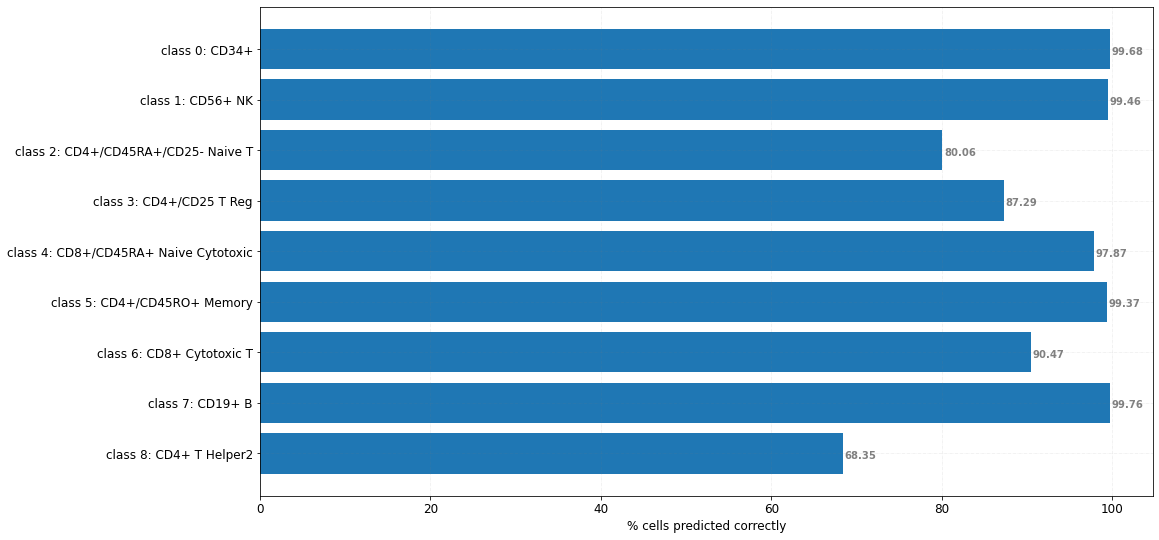

In [151]:
fig, ax = plt.subplots(figsize =(16, 9))
cls_ids_pure = ['CD34+', 'CD56+ NK', 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD25 T Reg', \
               'CD8+/CD45RA+ Naive Cytotoxic', 'CD4+/CD45RO+ Memory', 'CD8+ Cytotoxic T', \
               'CD19+ B', 'CD4+ T Helper2']
cls_ids_pure_modified = [('class ' + str(i) + ': ' + cls_ids_pure[i]) for i in range(len(cls_ids_pure))]

ax.barh(cls_ids_pure_modified, acc_per_class)
ax.invert_yaxis()

# Add gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.xlabel('% cells predicted correctly')
plt.show()

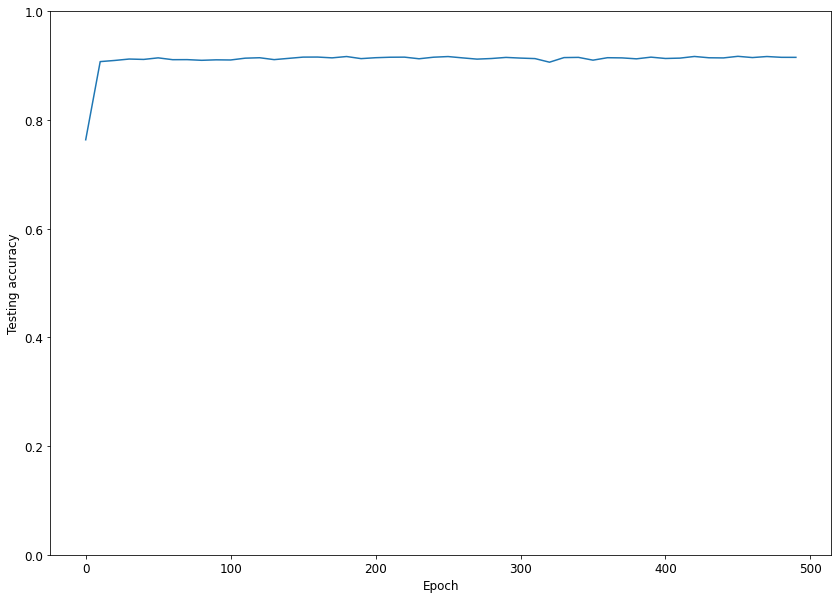

In [101]:
# Plot testing accuracy over 500 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,500,10), model_performance['testing_accuracy'].dropna().tolist())
_ = plt.ylim([0, 1])
_ = plt.ylabel('Testing accuracy')
_ = plt.xlabel('Epoch')


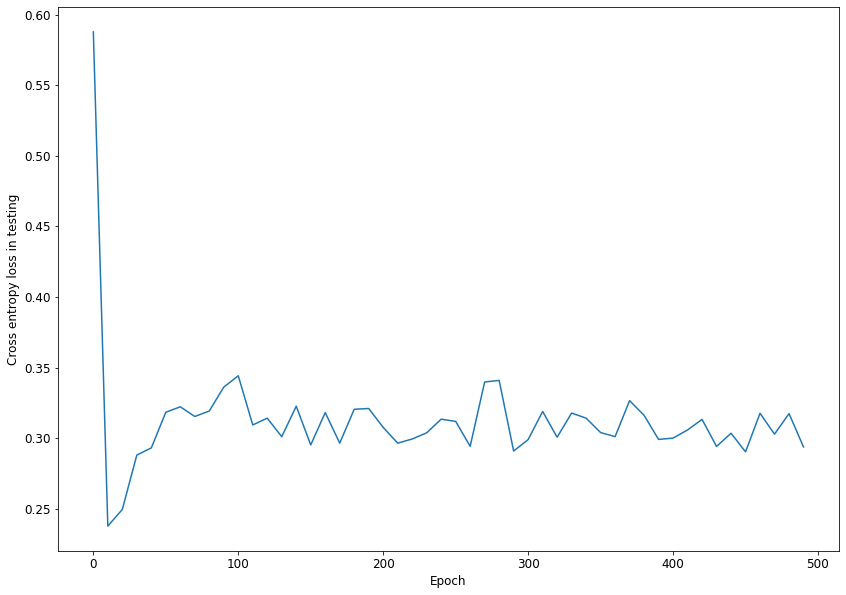

In [84]:
# Plot testing cross entropy loss over 500 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,500,10), model_performance['testing_loss'].dropna().tolist())

_ = plt.ylabel('Cross entropy loss in testing')
_ = plt.xlabel('Epoch')

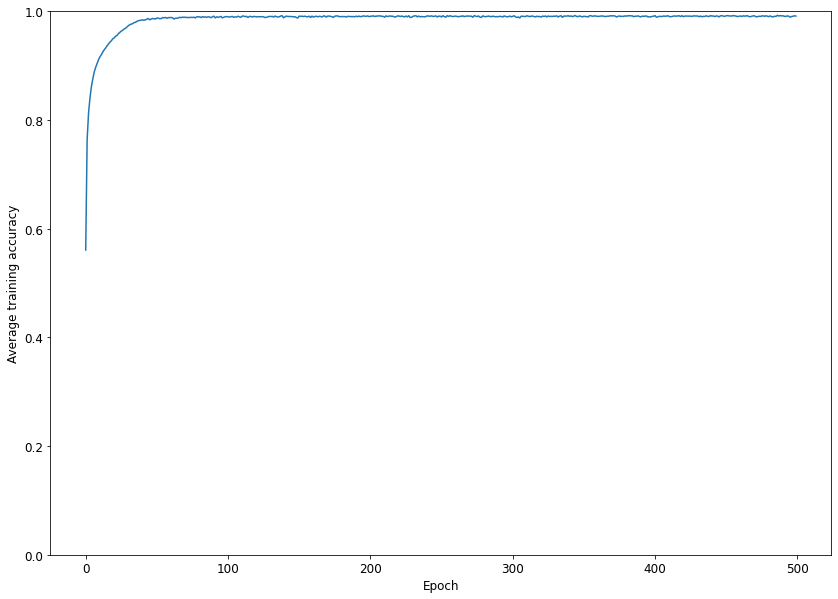

In [85]:
# Plot average training accuracy (over the batches) over 500 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,500,1), model_performance['training_accuracy_avg'].dropna().tolist())
_ = plt.ylim([0, 1])
_ = plt.ylabel('Average training accuracy')
_ = plt.xlabel('Epoch')

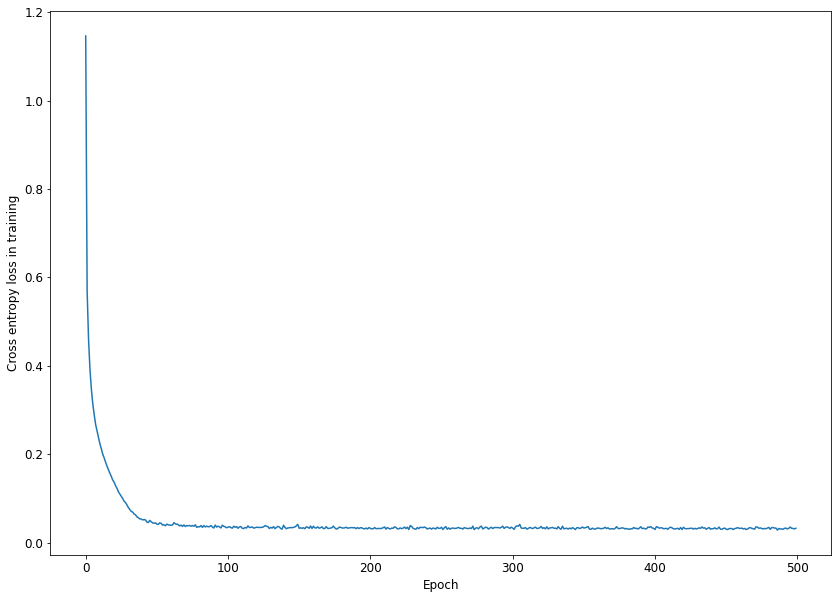

In [145]:
# Plot training cross entropy loss over 500 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,500,1), model_performance['training_loss_avg'].dropna().tolist())

_ = plt.ylabel('Cross entropy loss in training')
_ = plt.xlabel('Epoch')

In [121]:
# Plot ROC curves

# Evaluate the trained MLP model with test data
model.eval()

# Get raw predicted result
test_pred = model(torch.from_numpy(X_test).float())

# Apply softmax function to get probability for each class (one-hot encoding)
prob_pred = F.softmax(test_pred, dim = 1)

# Convert prediction back to numpy array
prob_pred_array = prob_pred.detach().numpy()

# Binarize labels
binarized_y = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
n_classes = binarized_y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_y[:, i], prob_pred_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(binarized_y.ravel(), prob_pred_array.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

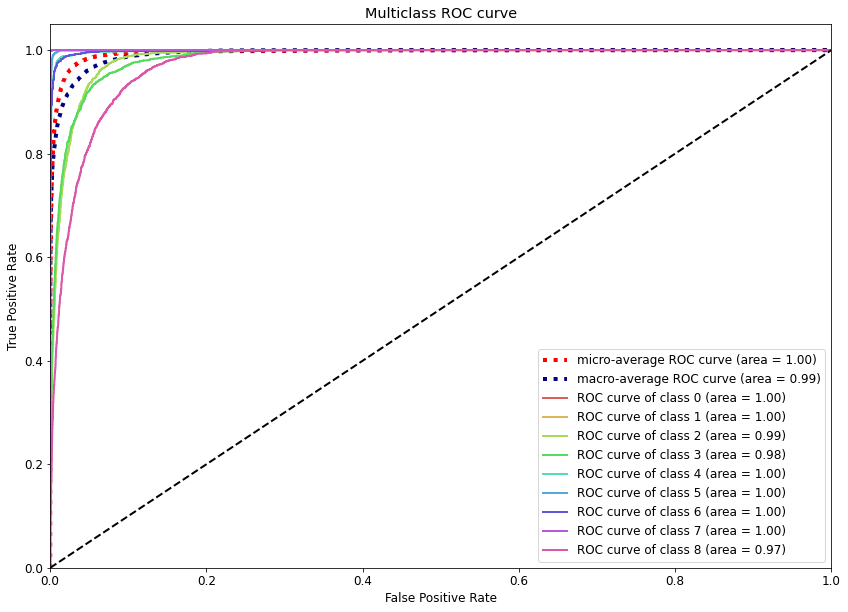

In [176]:
plt.figure(figsize =(14, 10))

plt.plot(
    fpr['micro'],
    tpr['micro'],
    label = 'micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color = 'red',
    linestyle = ':',
    linewidth = 4,
)

plt.plot(
    fpr['macro'],
    tpr['macro'],
    label = 'macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color = 'navy',
    linestyle = ':',
    linewidth = 4,
)

colors = sns.color_palette('hls', 9)
lw = 2

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color = color,
        lw = lw,
        label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc = 'lower right')
plt.show()

## 5. Evaluate MLP on PBMC68k data

In [38]:
# Change directory 

print("Original working directory: {0}".format(os.getcwd()))

path = '/Users/ryanyutian/Desktop/PBMC68k_project/input_data_68k'

try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except NotADirectoryError:
    print("{0} is not a directory".format(path))
except PermissionError:
    print("You do not have permissions to change to {0}".format(path))

Original working directory: /Users/ryanyutian/Desktop/PBMC68k_project/input_data_68k
Current working directory: /Users/ryanyutian/Desktop/PBMC68k_project/input_data_68k


In [39]:
# Import normalized expression matrix of the PBMC68k dataset

raw_normalized_expression_68k_mtx = mmread('normalized_expression.mtx')
normalized_expression_68k_array = raw_normalized_expression_68k_mtx.toarray(order='C')

In [40]:
# Import cell labels of the PBMC68k dataset

tsne_coord_and_cell_labels_df = pd.read_csv('tsne_coord_and_cell_labels.csv', index_col=0)
tsne_coord_and_cell_labels_df

,X1,X2,cls_id,k
1,-8.403355,-13.764636,CD8+ Cytotoxic T,5
2,-9.107338,16.789431,CD8+/CD45RA+ Naive Cytotoxic,7
3,5.606240,-16.794590,CD4+/CD25 T Reg,2
4,27.941755,-4.804062,CD19+ B,10
5,11.499637,17.448577,CD4+/CD25 T Reg,4
...,...,...,...,...
68575,-7.076824,15.620549,CD8+/CD45RA+ Naive Cytotoxic,7
68576,-6.351821,11.001483,CD8+/CD45RA+ Naive Cytotoxic,7
68577,-10.568153,-18.583696,CD8+ Cytotoxic T,5
68578,-9.786659,-18.490034,CD8+/CD45RA+ Naive Cytotoxic,5


In [41]:
# Pure class IDs
cls_ids_pure = ['CD34+', 'CD56+ NK', 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD25 T Reg', \
               'CD8+/CD45RA+ Naive Cytotoxic', 'CD4+/CD45RO+ Memory', 'CD8+ Cytotoxic T', \
               'CD19+ B', 'CD4+ T Helper2']

In [11]:
# Generate class identifiers for the PMBC68k data based on the pure class labels

cls_ids_68k = tsne_coord_and_cell_labels_df['cls_id'].tolist()

cls_labels_68k = []
normalized_expression_68k_array_processed = []

for i in range(len(normalized_expression_68k_array)):
    
    if cls_ids_68k[i] in cls_ids_pure:
        
        cls_labels_68k.append(cls_ids_pure.index(cls_ids_68k[i]))
        normalized_expression_68k_array_processed.append(normalized_expression_68k_array[i])
    
cls_labels_68k = np.array(cls_labels_68k)
normalized_expression_68k_array_processed = np.array(normalized_expression_68k_array_processed)

In [15]:
# Evaluate the trained MLP model with 68k data
model.eval()

# Get raw predicted result
test_pred = model(torch.from_numpy(normalized_expression_68k_array_processed).float())

# Compute test loss
print('Loss on the 68k data: ' + str(criterion(test_pred, torch.from_numpy(np.asarray(cls_labels_68k)).long())))

# Get predicted labels 
MLP_predicted_labels = get_label_from_MLP_output(test_pred)
temp_test_accuracy = np.mean(MLP_predicted_labels == cls_labels_68k)
print('Accuracy on the 68k data: ' + str(temp_test_accuracy))

Loss on the 68k data: tensor(5.5076, grad_fn=<NllLossBackward>)
Accuracy on the 68k data: 0.23514383043149129


In [40]:
np.unique(cls_labels_68k, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  262,  5859,  2793, 14112, 21975,  3126, 11445,  3817,    19]))

In [41]:
np.unique(cls_labels_68k[MLP_predicted_labels == cls_labels_68k], return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 652,  885, 4138, 1054,  221, 4273, 3675,   12]))

In [43]:
# Evaluate accuracy for each class:
orig_cls_id = [0, 1, 2, 3, 4, 5, 6, 7, 8]
orig_cls_count = [262, 5859, 2793, 14112, 21975, 3126, 11445, 3817, 19]

test_cls_id = [0, 1, 2, 3, 4, 5, 6, 7, 8]
correct_pred_count = [0, 652, 885, 4138, 1054, 221, 4273, 3675, 12]

acc_per_class = []
for i in range(len(orig_cls_count)):
    
    print('There are '  + str(orig_cls_count[i]) + ' cells in class ' + str(orig_cls_id[i]))
    print('The model predicted '  + str(correct_pred_count[i]) + ' cells correctly for class ' \
          + str(test_cls_id[i]))
    print('Accuracy for class '  + str(orig_cls_id[i]) + ' is therefore: ' + \
          str(100 * correct_pred_count[i]/orig_cls_count[i]) + '%')
    print('\n')
    acc_per_class.append(100 * correct_pred_count[i]/orig_cls_count[i])

There are 262 cells in class 0
The model predicted 0 cells correctly for class 0
Accuracy for class 0 is therefore: 0.0%


There are 5859 cells in class 1
The model predicted 652 cells correctly for class 1
Accuracy for class 1 is therefore: 11.128178870114354%


There are 2793 cells in class 2
The model predicted 885 cells correctly for class 2
Accuracy for class 2 is therefore: 31.68635875402793%


There are 14112 cells in class 3
The model predicted 4138 cells correctly for class 3
Accuracy for class 3 is therefore: 29.322562358276645%


There are 21975 cells in class 4
The model predicted 1054 cells correctly for class 4
Accuracy for class 4 is therefore: 4.796359499431172%


There are 3126 cells in class 5
The model predicted 221 cells correctly for class 5
Accuracy for class 5 is therefore: 7.069737683941139%


There are 11445 cells in class 6
The model predicted 4273 cells correctly for class 6
Accuracy for class 6 is therefore: 37.33508082131935%


There are 3817 cells in class

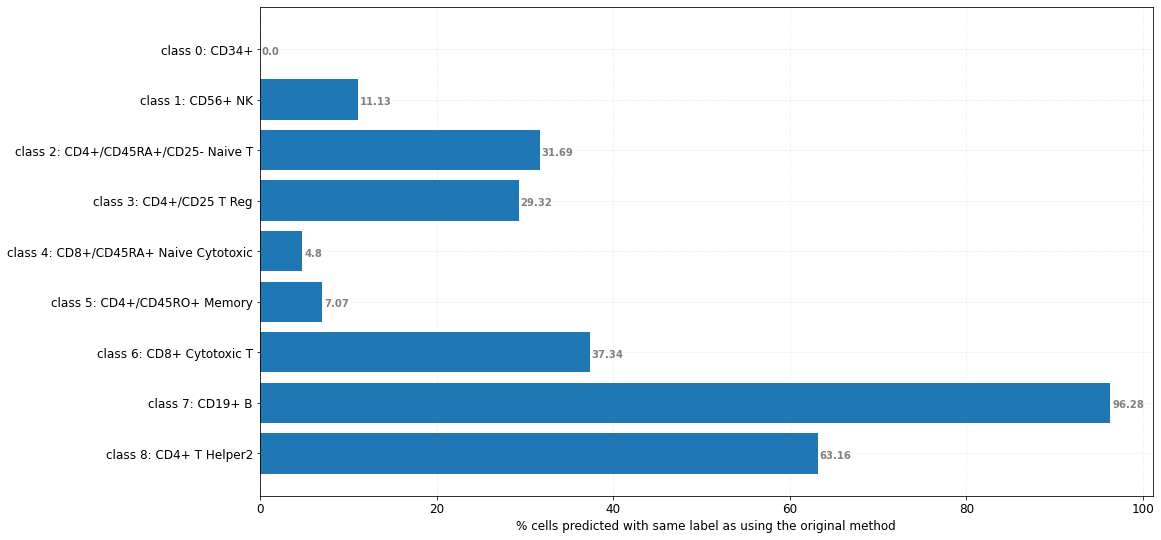

In [50]:
fig, ax = plt.subplots(figsize =(16, 9))

cls_ids_pure = ['CD34+', 'CD56+ NK', 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD25 T Reg', \
               'CD8+/CD45RA+ Naive Cytotoxic', 'CD4+/CD45RO+ Memory', 'CD8+ Cytotoxic T', \
               'CD19+ B', 'CD4+ T Helper2']
cls_ids_pure_modified = [('class ' + str(i) + ': ' + cls_ids_pure[i]) for i in range(len(cls_ids_pure))]

ax.barh(cls_ids_pure_modified, acc_per_class)
ax.invert_yaxis()

# Add gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.xlabel('% cells predicted with same label as using the original method')
plt.show()

In [45]:
# Plot ROC curves

# Evaluate the trained MLP model with test data
model.eval()

# Get raw predicted result
test_pred = model(torch.from_numpy(normalized_expression_68k_array_processed).float())

# Apply softmax function to get probability for each class (one-hot encoding)
prob_pred = F.softmax(test_pred, dim = 1)

# Convert prediction back to numpy array
prob_pred_array = prob_pred.detach().numpy()

# Binarize labels
binarized_y = label_binarize(cls_labels_68k, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
n_classes = binarized_y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_y[:, i], prob_pred_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(binarized_y.ravel(), prob_pred_array.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

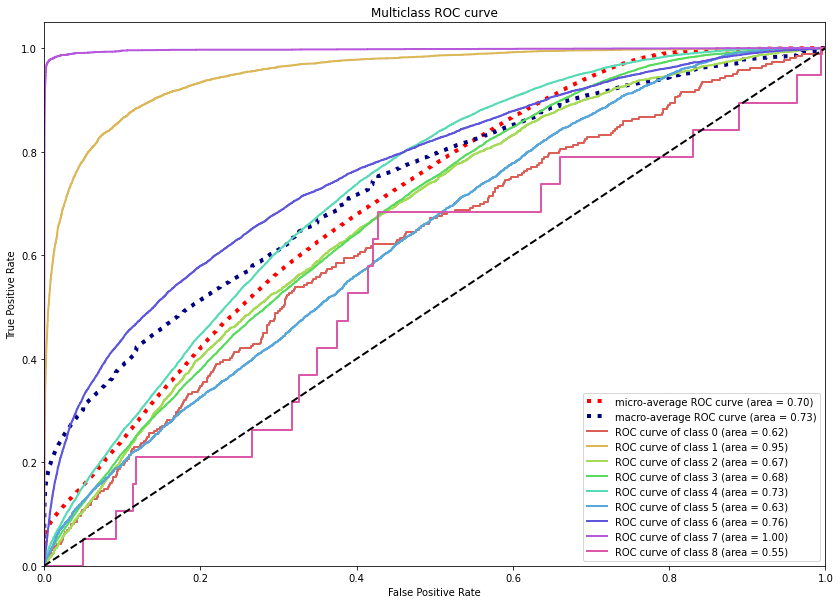

In [46]:
plt.figure(figsize =(14, 10))

plt.plot(
    fpr['micro'],
    tpr['micro'],
    label = 'micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color = 'red',
    linestyle = ':',
    linewidth = 4,
)

plt.plot(
    fpr['macro'],
    tpr['macro'],
    label = 'macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color = 'navy',
    linestyle = ':',
    linewidth = 4,
)

colors = sns.color_palette('hls', 9)
lw = 2

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color = color,
        lw = lw,
        label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc = 'lower right')
plt.show()

## 6. Train same model on PBMC68k data

Since the model was not generalizable when trained on the pure dataset, then evaluated on the PBMC68k data, a model should be trained solely on the PBMC68k data to prove that there is some intrinsic patterns to be captured.

In [61]:
# Split training and testing set from the PBMC68k data

X_train, X_test, y_train, y_test = \
train_test_split(normalized_expression_68k_array_processed, cls_labels_68k, test_size=0.20)

In [62]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  210,  4664,  2244, 11268, 17631,  2507,  9127,  3060,    15]))

In [63]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  52, 1195,  549, 2844, 4344,  619, 2318,  757,    4]))

In [64]:
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

trainloader = DataLoader(train_data, shuffle=True, batch_size=100)

In [66]:
# Initialize the NN with input_size, hidden_size, and output_size, and define loss function and optimizer
model = MLPNNet([32738, 100, 100], 9)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Number of times that the MLP will be trained on the train set
n_epochs = 500

# Lists to record model training and testing performance
train_loss_avg = []
test_loss = []
train_accuracy_avg = []
test_accuracy = []

print('Training ...')

# Loop through the training set to update parameters
for epoch in range(n_epochs):
    
    # Train the model
    model.train()

    # Initiate training performance calculation
    train_loss_avg.append(0)
    train_accuracy_avg.append(0)
    num_batches = 0
    
    for cell_batch, label_batch in trainloader:

        # Get an output by feeding data into the model
        out = model(torch.from_numpy(np.asarray(cell_batch)).float())

        # Compute loss from output
        loss = criterion(out, torch.from_numpy(np.asarray(label_batch)).long())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()
        
        # Update training performance calculation
        train_loss_avg[-1] += loss.item()
        train_accuracy_avg[-1] += np.mean(get_label_from_MLP_output(out) == np.array(label_batch))
        num_batches += 1
    
    # Finish training performance calculation
    train_loss_avg[-1] /= num_batches
    train_accuracy_avg[-1] /= num_batches

    print('Epoch [%d / %d] average training loss: %f' % (epoch+1, n_epochs, train_loss_avg[-1]))

    # Update other performance lists every 10 epochs
    if epoch % 10 == 0:
                              
        # Evaluate the trained MLP model with test data
        model.eval()

        # Get raw predicted result
        test_pred = model(torch.from_numpy(X_test).float())
        
        # Append test loss
        test_loss.append(float(criterion(test_pred, torch.from_numpy(np.asarray(y_test)).long())))

        # Get predicted labels 
        MLP_predicted_labels = get_label_from_MLP_output(test_pred)
        temp_test_accuracy = np.mean(MLP_predicted_labels == y_test)
        test_accuracy.append(temp_test_accuracy)
        

    # Print statement every 50 epochs to verify status and time taken
    if epoch % 50 == 0:
        
        print('Current epoch: ' + str(epoch + 1))
        print('Current time: ', datetime.now().strftime("%H:%M:%S"))
        print('Average train accuracy = ' + str(train_accuracy_avg[-1]))
        print('Test accuracy = ' + str(temp_test_accuracy))

Training ...
Epoch [1 / 500] average training loss: 1.584965
Current epoch: 1
Current time:  22:39:31
Average train accuracy = 0.381499091459721
Test accuracy = 0.512222046995742
Epoch [2 / 500] average training loss: 1.087125
Epoch [3 / 500] average training loss: 0.931857
Epoch [4 / 500] average training loss: 0.863110
Epoch [5 / 500] average training loss: 0.790335
Epoch [6 / 500] average training loss: 0.734075
Epoch [7 / 500] average training loss: 0.697069
Epoch [8 / 500] average training loss: 0.665781
Epoch [9 / 500] average training loss: 0.637185
Epoch [10 / 500] average training loss: 0.613754
Epoch [11 / 500] average training loss: 0.588480
Epoch [12 / 500] average training loss: 0.564642
Epoch [13 / 500] average training loss: 0.539733
Epoch [14 / 500] average training loss: 0.518809
Epoch [15 / 500] average training loss: 0.496765
Epoch [16 / 500] average training loss: 0.476732
Epoch [17 / 500] average training loss: 0.457751
Epoch [18 / 500] average training loss: 0.436

Epoch [158 / 500] average training loss: 0.058267
Epoch [159 / 500] average training loss: 0.060077
Epoch [160 / 500] average training loss: 0.061475
Epoch [161 / 500] average training loss: 0.055227
Epoch [162 / 500] average training loss: 0.060017
Epoch [163 / 500] average training loss: 0.056949
Epoch [164 / 500] average training loss: 0.060959
Epoch [165 / 500] average training loss: 0.051825
Epoch [166 / 500] average training loss: 0.056623
Epoch [167 / 500] average training loss: 0.054968
Epoch [168 / 500] average training loss: 0.052224
Epoch [169 / 500] average training loss: 0.058992
Epoch [170 / 500] average training loss: 0.057978
Epoch [171 / 500] average training loss: 0.057070
Epoch [172 / 500] average training loss: 0.055741
Epoch [173 / 500] average training loss: 0.052348
Epoch [174 / 500] average training loss: 0.052649
Epoch [175 / 500] average training loss: 0.053112
Epoch [176 / 500] average training loss: 0.057374
Epoch [177 / 500] average training loss: 0.057280


Epoch [315 / 500] average training loss: 0.046558
Epoch [316 / 500] average training loss: 0.055313
Epoch [317 / 500] average training loss: 0.050099
Epoch [318 / 500] average training loss: 0.054822
Epoch [319 / 500] average training loss: 0.060969
Epoch [320 / 500] average training loss: 0.048561
Epoch [321 / 500] average training loss: 0.056625
Epoch [322 / 500] average training loss: 0.063990
Epoch [323 / 500] average training loss: 0.057966
Epoch [324 / 500] average training loss: 0.061809
Epoch [325 / 500] average training loss: 0.061530
Epoch [326 / 500] average training loss: 0.055894
Epoch [327 / 500] average training loss: 0.055429
Epoch [328 / 500] average training loss: 0.052746
Epoch [329 / 500] average training loss: 0.060322
Epoch [330 / 500] average training loss: 0.059024
Epoch [331 / 500] average training loss: 0.067167
Epoch [332 / 500] average training loss: 0.052344
Epoch [333 / 500] average training loss: 0.055273
Epoch [334 / 500] average training loss: 0.052257


Epoch [472 / 500] average training loss: 0.050143
Epoch [473 / 500] average training loss: 0.054768
Epoch [474 / 500] average training loss: 0.054539
Epoch [475 / 500] average training loss: 0.050618
Epoch [476 / 500] average training loss: 0.050544
Epoch [477 / 500] average training loss: 0.050804
Epoch [478 / 500] average training loss: 0.056914
Epoch [479 / 500] average training loss: 0.051864
Epoch [480 / 500] average training loss: 0.052619
Epoch [481 / 500] average training loss: 0.056185
Epoch [482 / 500] average training loss: 0.063356
Epoch [483 / 500] average training loss: 0.057236
Epoch [484 / 500] average training loss: 0.056888
Epoch [485 / 500] average training loss: 0.057291
Epoch [486 / 500] average training loss: 0.059081
Epoch [487 / 500] average training loss: 0.056336
Epoch [488 / 500] average training loss: 0.054963
Epoch [489 / 500] average training loss: 0.054560
Epoch [490 / 500] average training loss: 0.055946
Epoch [491 / 500] average training loss: 0.057330


In [76]:
# Save trained model

path = '/Users/ryanyutian/Desktop/PBMC68k_project/models/100_100_MLP_PBMC/100_100_MLP.pt'

torch.save(model.state_dict(), path)

In [77]:
# Save model performance

output_df_dict = {'training_accuracy_avg': train_accuracy_avg, 'testing_accuracy': test_accuracy, \
                  'training_loss_avg': train_loss_avg, 'testing_loss': test_loss}
output_df = pd.DataFrame.from_dict(output_df_dict, orient='index')

path = '/Users/ryanyutian/Desktop/PBMC68k_project/models/100_100_MLP_PBMC'
output_df.to_csv((path + '/'  'performance.csv'), sep=',')

In [71]:
np.unique(y_test, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  52, 1195,  549, 2844, 4344,  619, 2318,  757,    4]))

In [70]:
np.unique(y_test[MLP_predicted_labels == y_test], return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([  46, 1009,   43, 2182, 3692,  126, 1986,  749]))

In [73]:
# Evaluate accuracy for each class:
orig_cls_id = [0, 1, 2, 3, 4, 5, 6, 7, 8]
orig_cls_count = [52, 1195, 549, 2844, 4344, 619, 2318, 757, 4]

test_cls_id = [0, 1, 2, 3, 4, 5, 6, 7, 8]
correct_pred_count = [46, 1009, 43, 2182, 3692, 126, 1986, 749, 0]

acc_per_class = []
for i in range(len(orig_cls_count)):
    
    print('There are '  + str(orig_cls_count[i]) + ' cells in class ' + str(orig_cls_id[i]))
    print('The model predicted '  + str(correct_pred_count[i]) + ' cells correctly for class ' \
          + str(test_cls_id[i]))
    print('Accuracy for class '  + str(orig_cls_id[i]) + ' is therefore: ' + \
          str(100 * correct_pred_count[i]/orig_cls_count[i]) + '%')
    print('\n')
    acc_per_class.append(100 * correct_pred_count[i]/orig_cls_count[i])

There are 52 cells in class 0
The model predicted 46 cells correctly for class 0
Accuracy for class 0 is therefore: 88.46153846153847%


There are 1195 cells in class 1
The model predicted 1009 cells correctly for class 1
Accuracy for class 1 is therefore: 84.43514644351464%


There are 549 cells in class 2
The model predicted 43 cells correctly for class 2
Accuracy for class 2 is therefore: 7.832422586520948%


There are 2844 cells in class 3
The model predicted 2182 cells correctly for class 3
Accuracy for class 3 is therefore: 76.72292545710268%


There are 4344 cells in class 4
The model predicted 3692 cells correctly for class 4
Accuracy for class 4 is therefore: 84.99079189686924%


There are 619 cells in class 5
The model predicted 126 cells correctly for class 5
Accuracy for class 5 is therefore: 20.355411954765753%


There are 2318 cells in class 6
The model predicted 1986 cells correctly for class 6
Accuracy for class 6 is therefore: 85.67730802415876%


There are 757 cells i

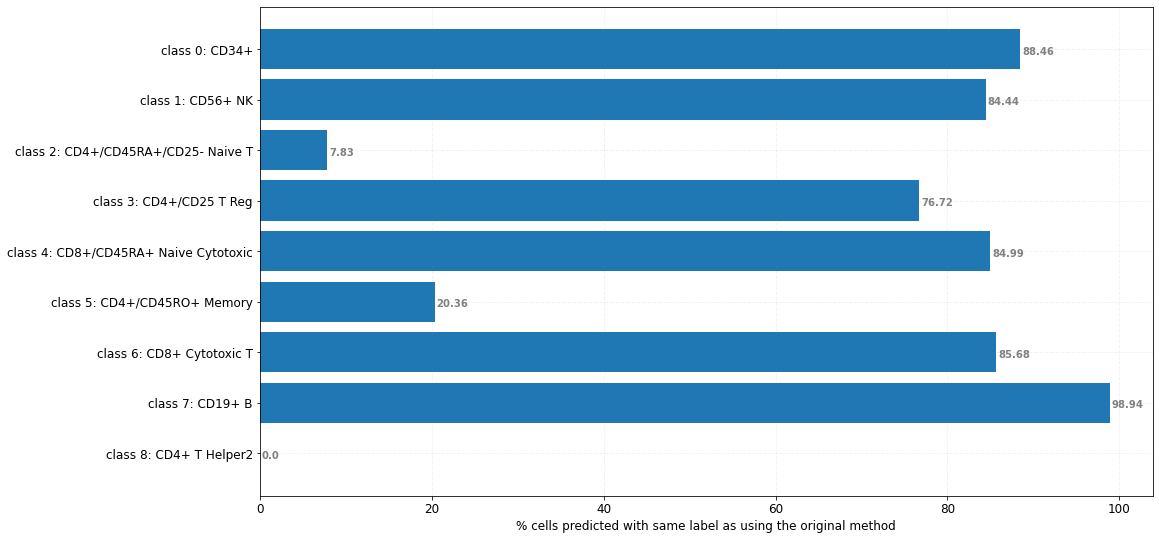

In [74]:
fig, ax = plt.subplots(figsize =(16, 9))

cls_ids_pure = ['CD34+', 'CD56+ NK', 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD25 T Reg', \
               'CD8+/CD45RA+ Naive Cytotoxic', 'CD4+/CD45RO+ Memory', 'CD8+ Cytotoxic T', \
               'CD19+ B', 'CD4+ T Helper2']
cls_ids_pure_modified = [('class ' + str(i) + ': ' + cls_ids_pure[i]) for i in range(len(cls_ids_pure))]

ax.barh(cls_ids_pure_modified, acc_per_class)
ax.invert_yaxis()

# Add gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.xlabel('% cells predicted with same label as using the original method')
plt.show()

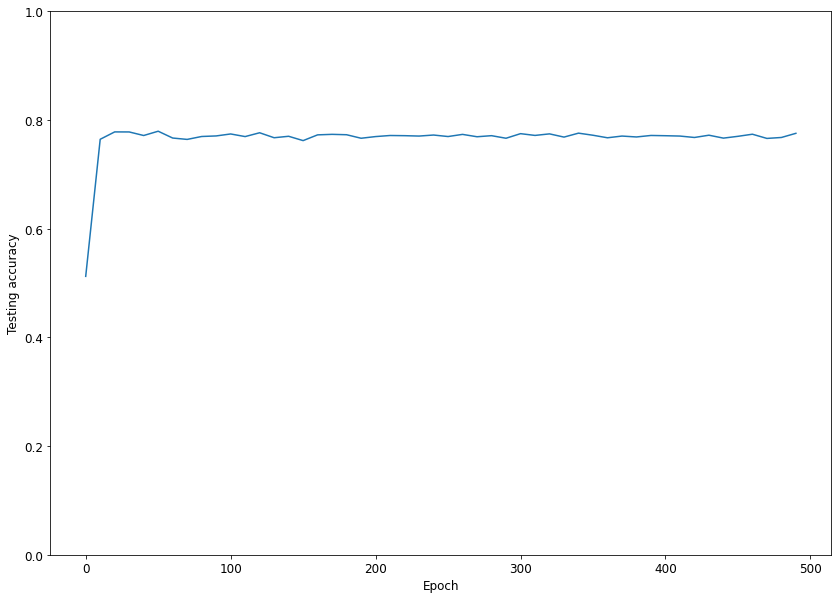

In [80]:
# Plot testing accuracy over 500 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,500,10), test_accuracy)
_ = plt.ylim([0, 1])
_ = plt.ylabel('Testing accuracy')
_ = plt.xlabel('Epoch')


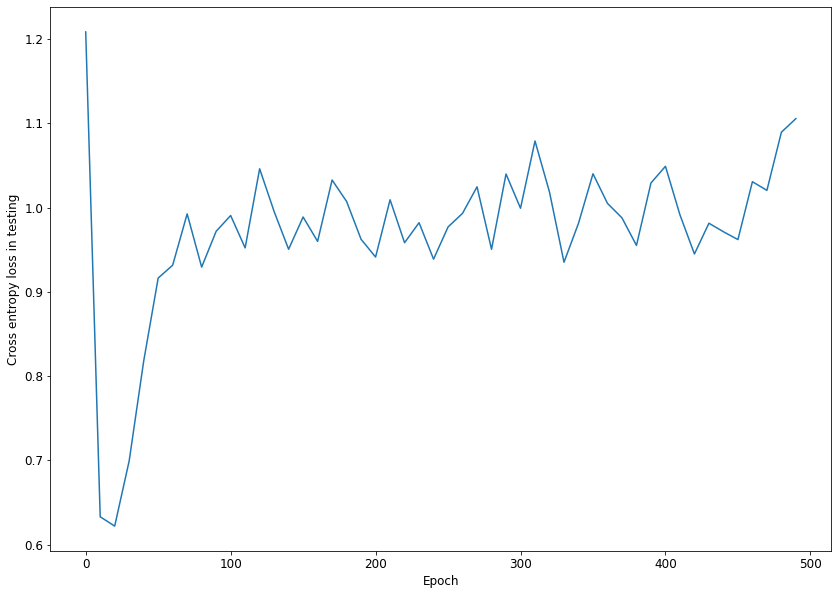

In [82]:
# Plot testing cross entropy loss over 500 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,500,10), test_loss)

_ = plt.ylabel('Cross entropy loss in testing')
_ = plt.xlabel('Epoch')

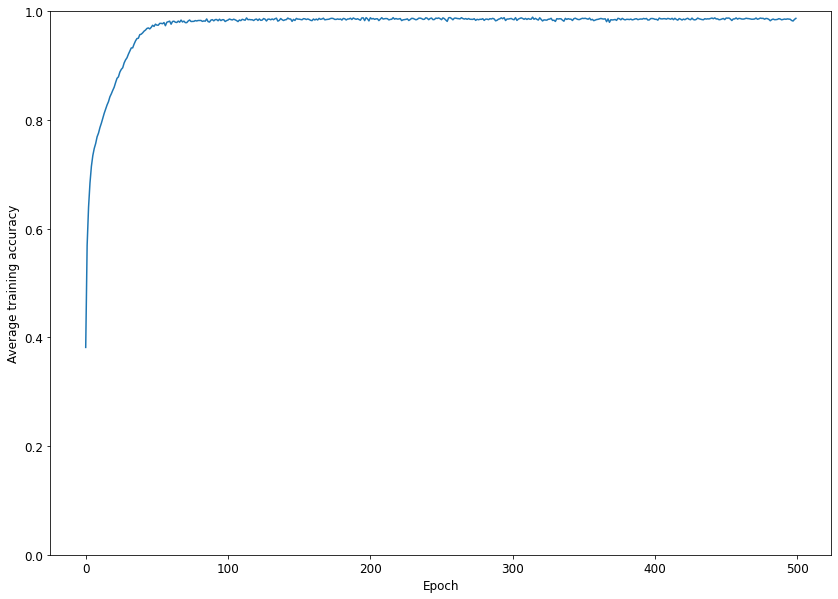

In [83]:
# Plot average training accuracy (over the batches) over 500 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,500,1), train_accuracy_avg)
_ = plt.ylim([0, 1])
_ = plt.ylabel('Average training accuracy')
_ = plt.xlabel('Epoch')

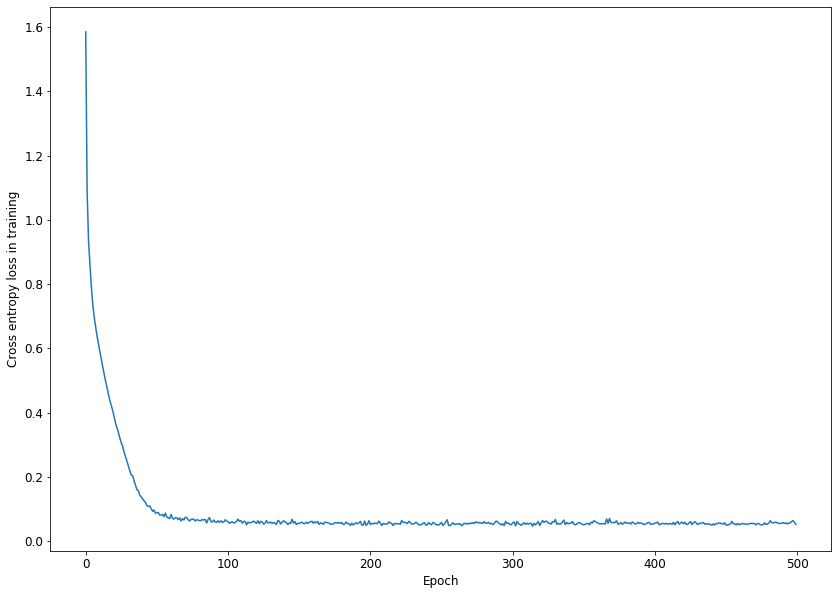

In [84]:
# Plot training cross entropy loss over 500 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,500,1), train_loss_avg)

_ = plt.ylabel('Cross entropy loss in training')
_ = plt.xlabel('Epoch')

In [85]:
# Plot ROC curves

# Evaluate the trained MLP model with test data
model.eval()

# Get raw predicted result
test_pred = model(torch.from_numpy(X_test).float())

# Apply softmax function to get probability for each class (one-hot encoding)
prob_pred = F.softmax(test_pred, dim = 1)

# Convert prediction back to numpy array
prob_pred_array = prob_pred.detach().numpy()

# Binarize labels
binarized_y = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
n_classes = binarized_y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_y[:, i], prob_pred_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(binarized_y.ravel(), prob_pred_array.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

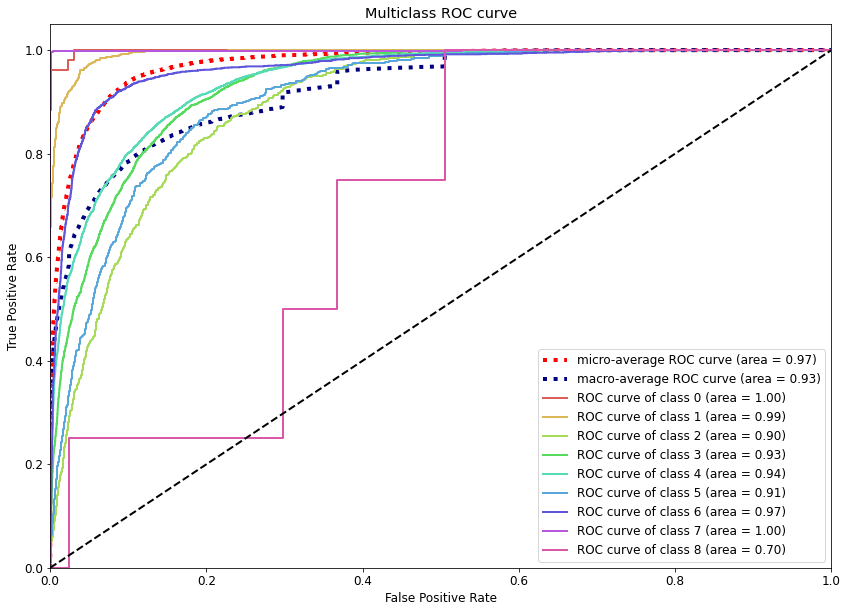

In [86]:
plt.figure(figsize =(14, 10))

plt.plot(
    fpr['micro'],
    tpr['micro'],
    label = 'micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color = 'red',
    linestyle = ':',
    linewidth = 4,
)

plt.plot(
    fpr['macro'],
    tpr['macro'],
    label = 'macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color = 'navy',
    linestyle = ':',
    linewidth = 4,
)

colors = sns.color_palette('hls', 9)
lw = 2

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color = color,
        lw = lw,
        label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc = 'lower right')
plt.show()

## 7. Train model on PBMC68k data, but using cluster labels as class labels

In [44]:
# Generate class identifiers for the PMBC68k data based on the pure class labels

cls_ids_68k_R = tsne_coord_and_cell_labels_df['k'].tolist()
cls_ids_68k = [(i-1) for i in cls_ids_68k_R]

In [47]:
# Split training and testing set from the PBMC68k data

X_train, X_test, y_train, y_test = \
train_test_split(normalized_expression_68k_array, cls_ids_68k, test_size=0.20)

In [48]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 3182,  9942,  2404, 14590,  6679,  5104,  5836,   131,  3575,
         3420]))

In [49]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 754, 2506,  604, 3664, 1647, 1258, 1475,   45,  896,  867]))

In [50]:
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

trainloader = DataLoader(train_data, shuffle=True, batch_size=100)

In [53]:
# Initialize the NN with input_size, hidden_size, and output_size, and define loss function and optimizer
model = MLPNNet([32738, 100, 100], 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Number of times that the MLP will be trained on the train set
n_epochs = 300

# Lists to record model training and testing performance
train_loss_avg = []
test_loss = []
train_accuracy_avg = []
test_accuracy = []

print('Training ...')

# Loop through the training set to update parameters
for epoch in range(n_epochs):
    
    # Train the model
    model.train()

    # Initiate training performance calculation
    train_loss_avg.append(0)
    train_accuracy_avg.append(0)
    num_batches = 0
    
    for cell_batch, label_batch in trainloader:

        # Get an output by feeding data into the model
        out = model(torch.from_numpy(np.asarray(cell_batch)).float())

        # Compute loss from output
        loss = criterion(out, torch.from_numpy(np.asarray(label_batch)).long())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()
        
        # Update training performance calculation
        train_loss_avg[-1] += loss.item()
        train_accuracy_avg[-1] += np.mean(get_label_from_MLP_output(out) == np.array(label_batch))
        num_batches += 1
    
    # Finish training performance calculation
    train_loss_avg[-1] /= num_batches
    train_accuracy_avg[-1] /= num_batches

    print('Epoch [%d / %d] average training loss: %f' % (epoch+1, n_epochs, train_loss_avg[-1]))

    # Update other performance lists every 10 epochs
    if epoch % 10 == 0:
                              
        # Evaluate the trained MLP model with test data
        model.eval()

        # Get raw predicted result
        test_pred = model(torch.from_numpy(X_test).float())
        
        # Append test loss
        test_loss.append(float(criterion(test_pred, torch.from_numpy(np.asarray(y_test)).long())))

        # Get predicted labels 
        MLP_predicted_labels = get_label_from_MLP_output(test_pred)
        temp_test_accuracy = np.mean(MLP_predicted_labels == y_test)
        test_accuracy.append(temp_test_accuracy)
        

    # Print statement every 50 epochs to verify status and time taken
    if epoch % 50 == 0:
        
        print('Current epoch: ' + str(epoch + 1))
        print('Current time: ', datetime.now().strftime("%H:%M:%S"))
        print('Average train accuracy = ' + str(train_accuracy_avg[-1]))
        print('Test accuracy = ' + str(temp_test_accuracy))

Training ...
Epoch [1 / 300] average training loss: 1.576182
Current epoch: 1
Current time:  21:02:38
Average train accuracy = 0.3963477607193457
Test accuracy = 0.612933799941674
Epoch [2 / 300] average training loss: 1.009125
Epoch [3 / 300] average training loss: 0.717195
Epoch [4 / 300] average training loss: 0.595746
Epoch [5 / 300] average training loss: 0.499174
Epoch [6 / 300] average training loss: 0.401014
Epoch [7 / 300] average training loss: 0.330752
Epoch [8 / 300] average training loss: 0.283616
Epoch [9 / 300] average training loss: 0.250405
Epoch [10 / 300] average training loss: 0.223863
Epoch [11 / 300] average training loss: 0.203300
Epoch [12 / 300] average training loss: 0.184050
Epoch [13 / 300] average training loss: 0.168250
Epoch [14 / 300] average training loss: 0.153767
Epoch [15 / 300] average training loss: 0.143100
Epoch [16 / 300] average training loss: 0.131235
Epoch [17 / 300] average training loss: 0.120586
Epoch [18 / 300] average training loss: 0.11

Epoch [158 / 300] average training loss: 0.028083
Epoch [159 / 300] average training loss: 0.028362
Epoch [160 / 300] average training loss: 0.029239
Epoch [161 / 300] average training loss: 0.026066
Epoch [162 / 300] average training loss: 0.027232
Epoch [163 / 300] average training loss: 0.026298
Epoch [164 / 300] average training loss: 0.028187
Epoch [165 / 300] average training loss: 0.027929
Epoch [166 / 300] average training loss: 0.028712
Epoch [167 / 300] average training loss: 0.027750
Epoch [168 / 300] average training loss: 0.030732
Epoch [169 / 300] average training loss: 0.028167
Epoch [170 / 300] average training loss: 0.027191
Epoch [171 / 300] average training loss: 0.028468
Epoch [172 / 300] average training loss: 0.028596
Epoch [173 / 300] average training loss: 0.027325
Epoch [174 / 300] average training loss: 0.028556
Epoch [175 / 300] average training loss: 0.026912
Epoch [176 / 300] average training loss: 0.028226
Epoch [177 / 300] average training loss: 0.028453


In [54]:
# Save trained model

path = '/Users/ryanyutian/Desktop/PBMC68k_project/models/100_100_MLP_PBMC_cluster/100_100_MLP.pt'

torch.save(model.state_dict(), path)

In [79]:
# Save model performance

output_df_dict = {'training_accuracy_avg': train_accuracy_avg, 'testing_accuracy': test_accuracy, \
                  'training_loss_avg': train_loss_avg, 'testing_loss': test_loss}
output_df = pd.DataFrame.from_dict(output_df_dict, orient='index')

path = '/Users/ryanyutian/Desktop/PBMC68k_project/models/100_100_MLP_PBMC_cluster'
output_df.to_csv((path + '/'  'performance.csv'), sep=',')

In [66]:
np.unique(y_test, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 754, 2506,  604, 3664, 1647, 1258, 1475,   45,  896,  867]))

In [67]:
orig_cls_id, orig_cls_count = np.unique(y_test, return_counts = True)

In [64]:
test_cls_id, correct_pred_count = \
np.unique(np.array(y_test)[MLP_predicted_labels == y_test], return_counts = True)

In [65]:
# Evaluate accuracy for each class:

acc_per_class = []
for i in range(len(orig_cls_count)):
    
    print('There are '  + str(orig_cls_count[i]) + ' cells in class ' + str(orig_cls_id[i]))
    print('The model predicted '  + str(correct_pred_count[i]) + ' cells correctly for class ' \
          + str(test_cls_id[i]))
    print('Accuracy for class '  + str(orig_cls_id[i]) + ' is therefore: ' + \
          str(100 * correct_pred_count[i]/orig_cls_count[i]) + '%')
    print('\n')
    acc_per_class.append(100 * correct_pred_count[i]/orig_cls_count[i])

There are 754 cells in class 0
The model predicted 740 cells correctly for class 0
Accuracy for class 0 is therefore: 98.14323607427056%


There are 2506 cells in class 1
The model predicted 2100 cells correctly for class 1
Accuracy for class 1 is therefore: 83.79888268156425%


There are 604 cells in class 2
The model predicted 524 cells correctly for class 2
Accuracy for class 2 is therefore: 86.75496688741723%


There are 3664 cells in class 3
The model predicted 3504 cells correctly for class 3
Accuracy for class 3 is therefore: 95.63318777292577%


There are 1647 cells in class 4
The model predicted 1491 cells correctly for class 4
Accuracy for class 4 is therefore: 90.52823315118397%


There are 1258 cells in class 5
The model predicted 1207 cells correctly for class 5
Accuracy for class 5 is therefore: 95.94594594594595%


There are 1475 cells in class 6
The model predicted 1352 cells correctly for class 6
Accuracy for class 6 is therefore: 91.66101694915254%


There are 45 cell

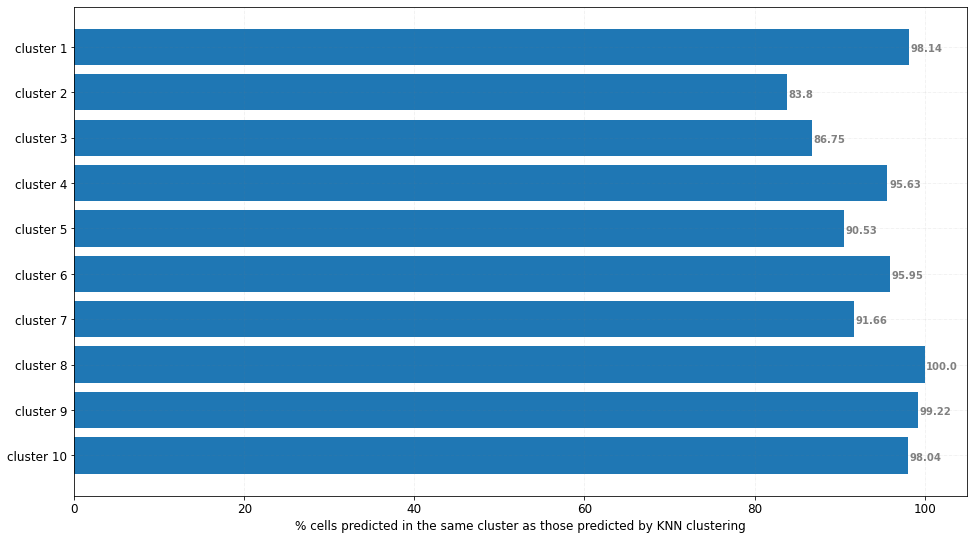

In [71]:
fig, ax = plt.subplots(figsize =(16, 9))

cls_ids = [('cluster ' + str(i + 1)) for i in range(len(acc_per_class))]

ax.barh(cls_ids, acc_per_class)
ax.invert_yaxis()

# Add gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.xlabel('% cells predicted in the same cluster as those predicted by KNN clustering')
plt.show()

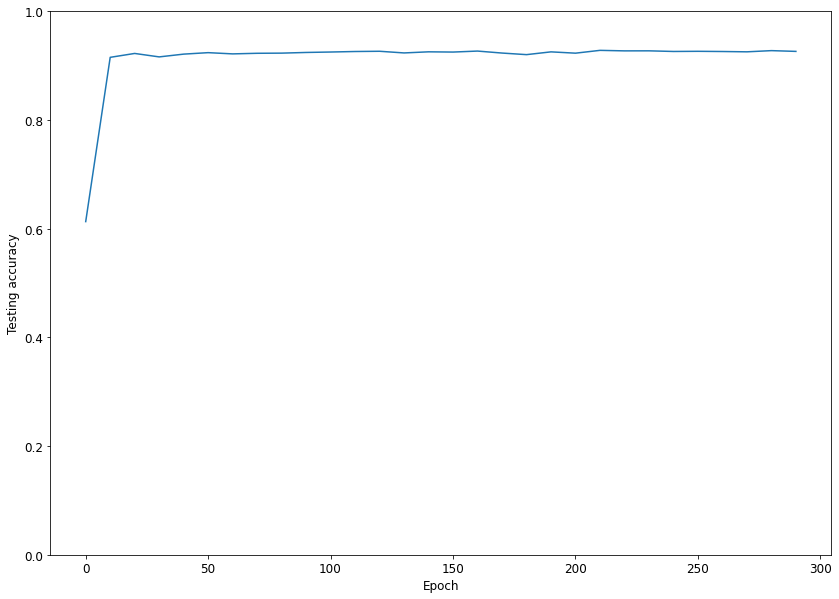

In [72]:
# Plot testing accuracy over 300 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,300,10), test_accuracy)
_ = plt.ylim([0, 1])
_ = plt.ylabel('Testing accuracy')
_ = plt.xlabel('Epoch')

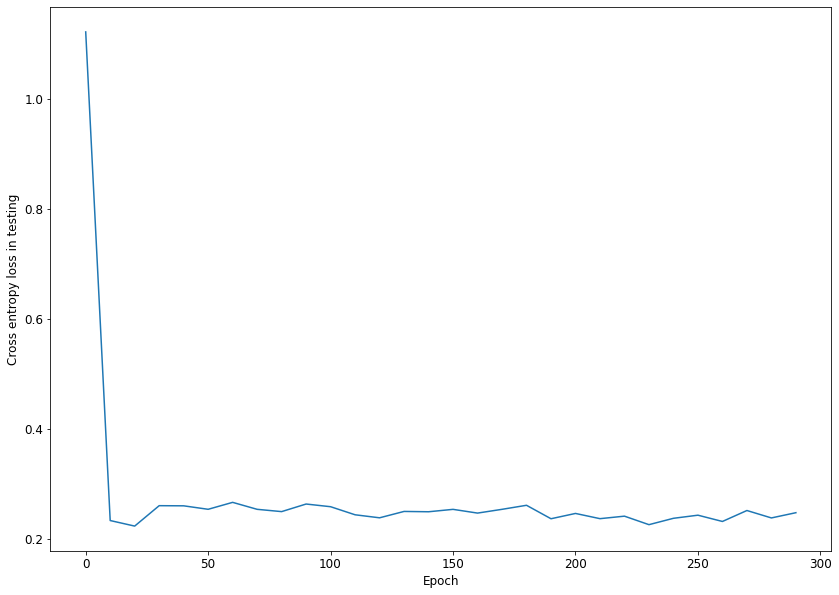

In [73]:
# Plot testing cross entropy loss over 300 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,300,10), test_loss)

_ = plt.ylabel('Cross entropy loss in testing')
_ = plt.xlabel('Epoch')

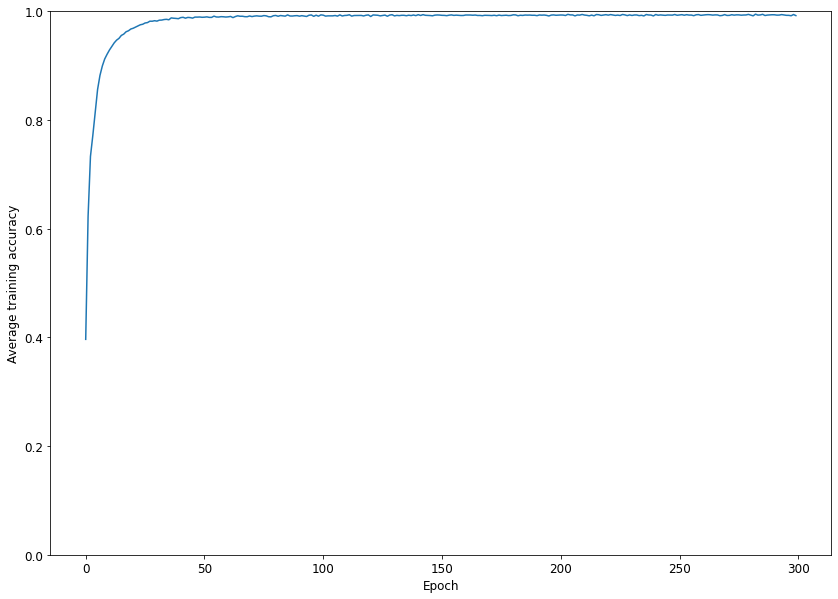

In [74]:
# Plot average training accuracy (over the batches) over 300 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,300,1), train_accuracy_avg)
_ = plt.ylim([0, 1])
_ = plt.ylabel('Average training accuracy')
_ = plt.xlabel('Epoch')

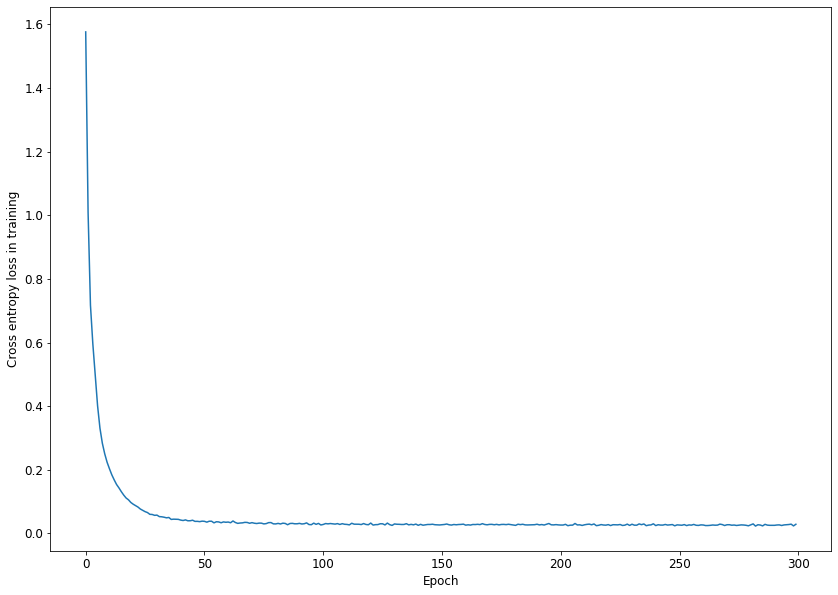

In [76]:
# Plot training cross entropy loss over 300 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,300,1), train_loss_avg)

_ = plt.ylabel('Cross entropy loss in training')
_ = plt.xlabel('Epoch')

In [77]:
# Plot ROC curves

# Evaluate the trained MLP model with test data
model.eval()

# Get raw predicted result
test_pred = model(torch.from_numpy(X_test).float())

# Apply softmax function to get probability for each class (one-hot encoding)
prob_pred = F.softmax(test_pred, dim = 1)

# Convert prediction back to numpy array
prob_pred_array = prob_pred.detach().numpy()

# Binarize labels
binarized_y = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = binarized_y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_y[:, i], prob_pred_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(binarized_y.ravel(), prob_pred_array.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

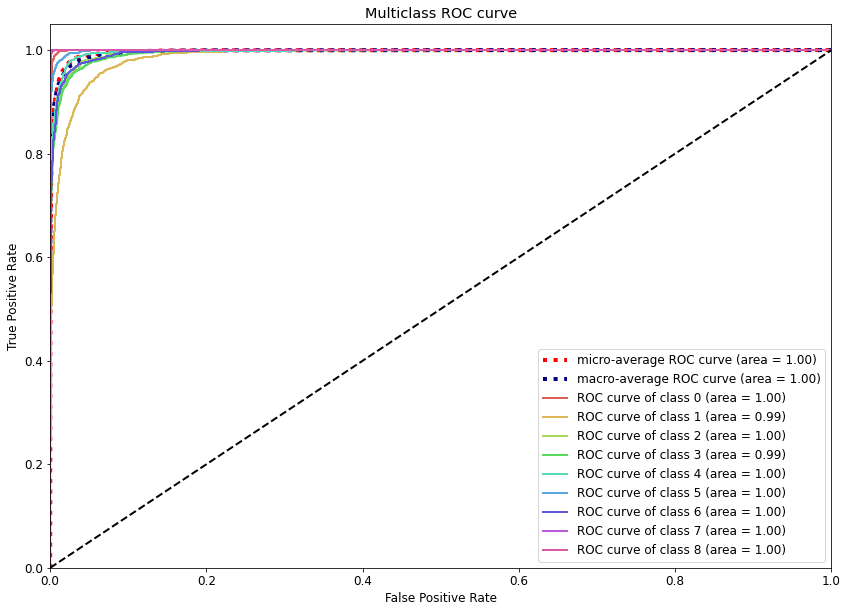

In [78]:
plt.figure(figsize =(14, 10))

plt.plot(
    fpr['micro'],
    tpr['micro'],
    label = 'micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color = 'red',
    linestyle = ':',
    linewidth = 4,
)

plt.plot(
    fpr['macro'],
    tpr['macro'],
    label = 'macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color = 'navy',
    linestyle = ':',
    linewidth = 4,
)

colors = sns.color_palette('hls', 9)
lw = 2

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color = color,
        lw = lw,
        label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
plt.legend(loc = 'lower right')
plt.show()